In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import gc
from utils.vis_shap import summary_legacy as summary_legacy2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
import pickle
import copy

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn import metrics as m
from sklearn.preprocessing import OneHotEncoder

import shap
from shap.plots import colors

SystemError: initialization of _internal failed without raising an exception

In [ ]:
train_df = pd.read_csv('active_learning_training_data.csv')
train_df

In [5]:
X_COLS = ['CNT', 'MXN', 'GNP', 'PVA', '1D', '2D', '2D1D', '2D2D', 'Pre-stretch', 'thickness']

Y_COLS_1 = ['trans_strain']
Y_COLS_2 = ['R0']

In [6]:
X_train, y_train_1, y_train_2 = train_df[X_COLS], train_df[Y_COLS_1], train_df[Y_COLS_2]

# Transition Strain

In [7]:
pickle_in = open('ann_tstrain_rd08_14.pickle', 'rb')
ann_tstrain = pickle.load(pickle_in)
pickle_in.close()

Trying to unpickle estimator StandardScaler from version 1.1.3 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator FunctionTransformer from version 1.1.3 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator Pipeline from version 1.1.3 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [8]:
explainer = shap.Explainer(ann_tstrain['trans_strain'].predict, X_train)

In [9]:
shap_values = explainer(X_train)

Exact explainer: 147it [01:02,  2.16it/s]                                                                              


In [10]:
MORPH_COLS = ['1D', '2D', '2D1D', '2D2D']

mod_shap_df = pd.DataFrame(shap_values.data, columns=X_COLS).join(pd.DataFrame(shap_values.values, columns=X_COLS), rsuffix='_SHAP')
mod_shap_df

mod_shap_df['MorphologyLabel'] = [sorted(MORPH_COLS, key=lambda c: r[c])[-1] for _, r in mod_shap_df.iterrows()]
mod_shap_df['Morphology'] = [MORPH_COLS.index(s) / 3.0 for s in mod_shap_df['MorphologyLabel']]
mod_shap_df['Morphology_SHAP'] = [r[f'{r.MorphologyLabel}_SHAP'] for _, r in mod_shap_df.iterrows()]
mod_shap_df

,CNT,MXN,GNP,PVA,1D,2D,2D1D,2D2D,Pre-stretch,thickness,...,PVA_SHAP,1D_SHAP,2D_SHAP,2D1D_SHAP,2D2D_SHAP,Pre-stretch_SHAP,thickness_SHAP,MorphologyLabel,Morphology,Morphology_SHAP
0,0.200000,0.610000,0.150000,0.040000,1.0,0.0,0.0,0.0,0.0,1200.0,...,-0.045953,-0.623198,0.107126,-0.264048,-0.124908,-0.676554,-0.033299,1D,0.000000,-0.623198
1,0.800000,0.050000,0.050000,0.100000,0.0,0.0,0.0,1.0,100.0,1200.0,...,-0.139684,0.120005,0.151312,-0.395640,0.295738,-0.448799,0.003196,2D2D,1.000000,0.295738
2,0.400000,0.460000,0.100000,0.040000,0.0,0.0,0.0,1.0,300.0,1200.0,...,-0.005277,0.172733,0.190189,-0.610019,0.449599,0.983613,0.015937,2D2D,1.000000,0.449599
3,0.400000,0.560000,0.000000,0.040000,0.0,0.0,1.0,0.0,100.0,800.0,...,-0.007730,0.125336,0.133890,0.429960,-0.170772,-0.410265,-0.100963,2D1D,0.666667,0.429960
4,0.150000,0.670000,0.150000,0.030000,0.0,0.0,1.0,0.0,100.0,1200.0,...,-0.054311,0.100443,0.125810,0.443892,-0.175115,-0.473805,0.048920,2D1D,0.666667,0.443892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0.316543,0.227505,0.433186,0.022766,1.0,0.0,0.0,0.0,0.0,800.0,...,-0.112147,-0.631338,0.097955,-0.233347,-0.127239,-0.765215,-0.095616,1D,0.000000,-0.631338
142,0.279193,0.204776,0.492918,0.023113,0.0,0.0,0.0,1.0,200.0,1200.0,...,0.181713,0.237060,0.235711,-0.400395,0.628708,0.803937,0.257725,2D2D,1.000000,0.628708
143,0.474030,0.333257,0.135878,0.056835,0.0,0.0,1.0,0.0,100.0,1600.0,...,0.081944,0.129870,0.142056,0.450924,-0.098529,-0.477906,0.013881,2D1D,0.666667,0.450924
144,0.378706,0.452909,0.127412,0.040973,0.0,0.0,1.0,0.0,200.0,1600.0,...,0.191111,0.198981,0.204946,0.745506,-0.171170,0.649445,0.094502,2D1D,0.666667,0.745506


In [11]:
mod_shap_df['Morphology'] = [MORPH_COLS.index(s) / 3.0 for s in mod_shap_df['MorphologyLabel']]
mod_shap_df['Morphology_SHAP'] = [r[f'{r.MorphologyLabel}_SHAP'] for _, r in mod_shap_df.iterrows()]

In [12]:
MOD_X_COLS = ['CNT', 'MXN', 'GNP', 'PVA', 'Morphology','Pre-stretch', 'thickness']
mod_shap_values = copy.deepcopy(shap_values)
mod_shap_values.values = copy.deepcopy(mod_shap_df[[f'{c}_SHAP' for c in MOD_X_COLS]].values)
mod_shap_values.data   = copy.deepcopy(mod_shap_df[[f'{c}'      for c in MOD_X_COLS]].values)
mod_shap_values.base_values = np.array([mod_shap_values.base_values[0], ] * len(mod_shap_df))

mod_shap_values

.values =
array([[-0.0340455 , -0.047191  , -0.05639227, ..., -0.62319766,
        -0.67655365, -0.03329939],
       [ 0.04074083,  0.05955358, -0.11133693, ...,  0.29573779,
        -0.44879919,  0.00319577],
       [-0.19990185, -0.36407477, -0.11689706, ...,  0.44959943,
         0.98361315,  0.015937  ],
       ...,
       [-0.0156308 , -0.05079494, -0.06239542, ...,  0.45092392,
        -0.47790631,  0.01388071],
       [-0.04433205, -0.06008686, -0.09097056, ...,  0.74550629,
         0.64944471,  0.09450199],
       [ 0.48682492,  0.29857871, -0.02261767, ...,  0.48174228,
         1.6569755 , -0.09220675]])

.base_values =
array([2.48877092, 2.48877092, 2.48877092, 2.48877092, 2.48877092,
       2.48877092, 2.48877092, 2.48877092, 2.48877092, 2.48877092,
       2.48877092, 2.48877092, 2.48877092, 2.48877092, 2.48877092,
       2.48877092, 2.48877092, 2.48877092, 2.48877092, 2.48877092,
       2.48877092, 2.48877092, 2.48877092, 2.48877092, 2.48877092,
       2.48877092, 2.48877

In [13]:
mod_shap_values_norm = copy.deepcopy(mod_shap_values)
mod_shap_values_norm.values /= np.max(np.abs(mod_shap_values_norm.values))
mod_shap_values_norm

.values =
array([[-0.01813838, -0.02514189, -0.03004404, ..., -0.33202028,
        -0.36044669, -0.01774087],
       [ 0.02170544,  0.03172829, -0.05931684, ...,  0.15755987,
        -0.23910621,  0.00170261],
       [-0.10650147, -0.19396768, -0.06227911, ...,  0.23953256,
         0.52403841,  0.00849074],
       ...,
       [-0.0083276 , -0.02706196, -0.03324233, ...,  0.2402382 ,
        -0.25461358,  0.00739521],
       [-0.02361873, -0.03201241, -0.04846628, ...,  0.39718251,
         0.34600389,  0.05034771],
       [ 0.25936514,  0.15907343, -0.01204999, ...,  0.25665726,
         0.88278487, -0.04912488]])

.base_values =
array([2.48877092, 2.48877092, 2.48877092, 2.48877092, 2.48877092,
       2.48877092, 2.48877092, 2.48877092, 2.48877092, 2.48877092,
       2.48877092, 2.48877092, 2.48877092, 2.48877092, 2.48877092,
       2.48877092, 2.48877092, 2.48877092, 2.48877092, 2.48877092,
       2.48877092, 2.48877092, 2.48877092, 2.48877092, 2.48877092,
       2.48877092, 2.48877

In [14]:
mod_shap_values_norm.data.shape

(146, 7)

In [20]:
X_COLS = ['SWNT', 'MXene', 'AuNP', 'PVA', 'Deformation Sequence', 'Pre-strain', 'Thickness']

In [29]:
tick_locs = [1.0, 1/2, 0]
base1 = mpl.colormaps.get_cmap('cividis')
color_list1 = base1(tick_locs)
cmap_name1 = base1.name + str(len(tick_locs))
cmap1 = plt.cm.colors.ListedColormap(color_list1, name=cmap_name1)

tick_locs = [1.0, 2/3, 1/3, 0]
base2 = mpl.colormaps.get_cmap('plasma')
color_list2 = base2(tick_locs)
cmap_name2 = base2.name + str(len(tick_locs))
cmap2 = plt.cm.colors.ListedColormap(color_list2, name=cmap_name2)

tick_locs = [1.0, 2/3, 1/3, 0]
base3 = mpl.colormaps.get_cmap('viridis')
color_list3 = base3(tick_locs)
cmap_name3 = base3.name + str(len(tick_locs))
cmap3 = plt.cm.colors.ListedColormap(color_list3, name=cmap_name3)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
FigureCanvasAgg is non-interactive, and thus cannot be shown


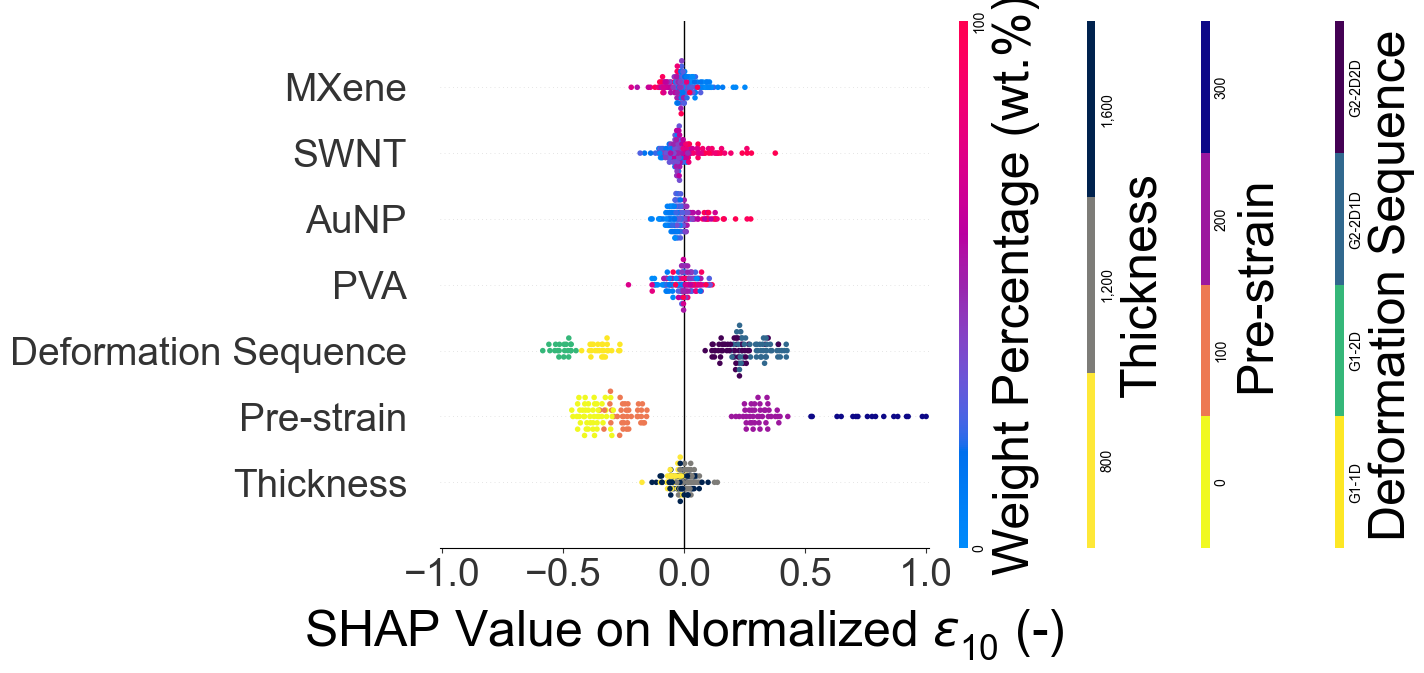

In [30]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.default'] = 'regular'

SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 36
# mpl.rcParams['font.family'] = prop.get_name()
plt.rc('legend', fontsize=28)    # legend fontsize
plt.rc('figure', titlesize=28)  # fontsize of the figure title

plt.close('all')


summary_legacy2(mod_shap_values_norm, mod_shap_values_norm.data, 
               feature_names=X_COLS, sort=False, plot_size=(12,6), 
               color_bar=False,
                 plot_idx=[6,5,4,3,2,0,1],
                cmaps=[colors.red_blue, colors.red_blue, colors.red_blue, colors.red_blue,
                         cmap3, cmap2, cmap1]
              )

fig = plt.gcf()
ax = plt.gca()

for cmap, fraction, label, ticks, ticklabels in [
        (cmap3,           0.10, 'Deformation Sequence', [1/8, 3/8, 5/8, 7/8], ['G1-1D', 'G1-2D', 'G2-2D1D', 'G2-2D2D']),
        (cmap2,           0.10, 'Pre-strain', [1/8, 3/8, 5/8, 7/8], ['0', '100', '200', '300']),
        (cmap1,           0.10, 'Thickness',    [1/6, 3/6, 5/6], ['800', '1,200', '1,600']),
        (colors.red_blue, 0.15, 'Weight Percentage (wt.%)', [0, 1], ['0', '100']),
        
    ]:
        m = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=cmap, )
        # m.set_array([0, 1])
        cbar = fig.colorbar(m, ticks=ticks, shrink=1.0, fraction=fraction, pad=0.05, aspect=60, ax=ax)
        
        
#         cbar = fig.colorbar(s1, ax=ax, shrink=0.5, pad=0.02, label='Solubility Group', ticks=[1/4, 3/4])
        cbar.set_ticklabels(ticklabels, rotation=90, va='center', ma='center')
        cbar.minorticks_off()
        cbar.ax.tick_params(axis='y', length=0)
        cbar.set_label(label, labelpad=4, fontsize=36)
        cbar.ax.tick_params(length=0)
        cbar.set_alpha(1)
        cbar.outline.set_visible(False)
#         arts.append(cbar.ax.yaxis.label)


ax.set_xlabel('SHAP Value on Normalized $\mathit{ε}_{10}$ (-)', fontsize=36, labelpad=10)
              
ax.set_xlim(-1.01, 1.01)
ax.set_xticks([-1,-0.5,0,0.5,1])
ax.tick_params(labelsize=28)

fig